In [2]:
import numpy as np
import pandas as pd 
import datetime

# imports
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
# from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Import TFIDFVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 

#tokenizers
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re



# Working off of Tanveer's Clean Data 

In [3]:
# to load file 
daily = pd.read_csv('/Users/plarkin/Downloads/daily.csv')
daily.head()

,Unnamed: 0,date,text,price,pct_change,price_direction,day_of_week,is_holiday
0,0,2011-07-29,"Drug App Comes Free, Ads Included. Epocrates h...",1292.28,NaN,first,4,0
1,1,2011-07-30,Global Concern Over U.S. Debt Ceiling Disagree...,1292.28,0.000000,same,5,0
2,2,2011-07-31,"Deal May Avert Default, but Some Ask, ‘Is That...",1292.28,0.000000,same,6,0
3,3,2011-08-01,"Charging a Premium for Movies, at a Cost. High...",1286.94,-0.004132,down,0,0
4,4,2011-08-02,"Pearls, Finer but Still Cheap, Flow From China...",1254.05,-0.025557,down,1,0


## Sentiment Analysis

#### Vader Sentiment Analysis

In [4]:
#Adding in Sentiment analysis with designated columns for each output (pos, neg, neu, compound)
analyzer = SentimentIntensityAnalyzer()

#daily['vader'] = daily['text'].map(lambda x:analyzer.polarity_scores(str(x)))


daily['vader_compound'] = [analyzer.polarity_scores(x)['compound'] for x in daily['text']]
# draft_df['vd_neg'] = [analyzer.polarity_scores(x)['neg'] for x in draft_df['alltext']]
# draft_df['vd_neu'] = [analyzer.polarity_scores(x)['neu'] for x in draft_df['alltext']]
# draft_df['vd_pos'] = [analyzer.polarity_scores(x)['pos'] for x in draft_df['alltext']]

%time


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs


#### Textblob Sentiment Analysis
source : https://neptune.ai/blog/sentiment-analysis-python-textblob-vs-vader-vs-flair

https://textblob.readthedocs.io/en/dev/

In [5]:
from textblob import TextBlob
#testimonial = TextBlob()
#draft_df['tb_polarity'] = [testimonial.polarity(x)['polarity'] for x in draft_df['alltext']]
#draft_df['tb_subj'] = [testimonial.sentiment(x)['subjectivity'] for x in draft_df['alltext']]
daily['textblob_polarity'] = daily['text'].map(lambda words: TextBlob(str(words)).polarity) #polarity is more applicable and comparable to vader compound. subjectivity is more about opinion vs fact 

%time


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.29 µs


In [6]:
daily.sort_values('textblob_polarity',ascending=True)

,Unnamed: 0,date,text,price,pct_change,price_direction,day_of_week,is_holiday,vader_compound,textblob_polarity
2591,2591,2018-09-08,Alex Jones’s Infowars Is Removed From Apple’s ...,2871.68,0.0,same,5,0,-0.9485,-0.333333
2216,2216,2017-08-26,James Staley’s Series of Unfortunate Events. A...,2443.05,0.0,same,5,0,-0.7717,-0.300000
155,155,2011-12-31,"After Outcry, Verizon Abandons $2 Fee. Verizon...",1257.60,0.0,same,5,0,-0.9393,-0.233333
3575,3575,2021-05-30,‘It’s Going to Be a Big Summer for Hard Seltze...,4204.11,0.0,same,6,0,-0.8582,-0.195606
3209,3209,2020-05-24,Pay Cuts Become a Tool for Some Companies to A...,2955.45,0.0,same,6,0,-0.9403,-0.151852
...,...,...,...,...,...,...,...,...,...,...
2264,2264,2017-10-14,Tesla Fires Hundreds of Workers. The dismissal...,2553.17,0.0,same,5,0,-0.4588,0.280769
1763,1763,2016-05-28,Paper Points Up Flaws in Venture Fund Based on...,2099.06,0.0,same,5,0,0.9862,0.288625
3347,3347,2020-10-10,Airline Miles Programs Sure Are Profitable. Ar...,3477.13,0.0,same,5,0,0.9886,0.311180
1589,1589,2015-12-06,You and What Army?. Part 1 of a cluing discuss...,2091.69,0.0,same,6,0,-0.6655,0.315278


<ipython-input-7-a4dfeba400c0>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  daily.groupby('price_direction')['vader_compound','textblob_polarity'].mean().T.plot(kind='bar', stacked=False)


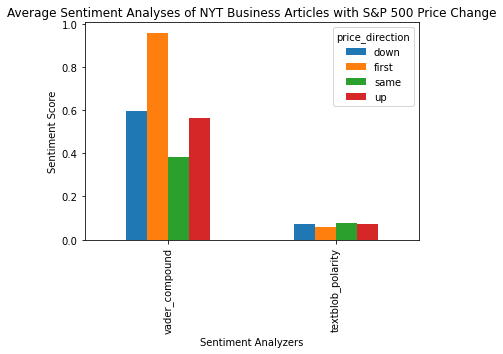

In [7]:
daily.groupby('price_direction')['vader_compound','textblob_polarity'].mean().T.plot(kind='bar', stacked=False)
plt.title('Average Sentiment Analyses of NYT Business Articles with S&P 500 Price Change')
plt.xlabel('Sentiment Analyzers')
plt.ylabel('Sentiment Score');

### Text Cleaning
eliminate the punctuation, URL, and @
#source: https://monkeylearn.com/blog/text-cleaning/

In [12]:
#Use this to remove http, punctuation, URL, and @
daily['text'] = daily['text'].map(lambda x: re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", str(x.lower())))


tokenize and lemmatize
(no longer lemmatizing, results from gridsearch showed superior accuracy without lemmatizing)

In [9]:
#convert price_direction to numerical and drop first row with NA value
daily.dropna(inplace=True)
daily['price_direction'] = daily['price_direction'].map({'down' : -1,'same' : 0 , 'up' : 1})

In [17]:
daily['price_direction'].value_counts()

 1    1391
-1    1137
 0    1124
Name: price_direction, dtype: int64

In [25]:
#declaring features and target variable for tfidf. It will not take an array as the X input
X = daily['text']
y = daily['price_direction']

In [14]:
X

1       global concern over us debt ceiling disagreeme...
2       deal may avert default but some ask is that go...
3       charging a premium for movies at a cost highpr...
4       pearls finer but still cheap flow from china c...
5       aaa rating is a rarity in business hanging ove...
                              ...                        
3648    6 ways to tame airline nightmares thousands of...
3649    like choosing a pope how succession got messy ...
3650    now going viral meeting online friends in real...
3651    japans economy returns to growth but virus thr...
3652    days may be numbered for the worlds oldest ban...
Name: text, Length: 3652, dtype: object

## Gridsearch with TFIDF and Multinomial Bayes

Less likely to use tFIDF since it is looking for relative and rare words across documents to weight them in comparison and that isn't necessarily the goal of our analysis. Weighting words is less important than finding sentiment from counting words. WRONG

Text(0, 0.5, 'Words')

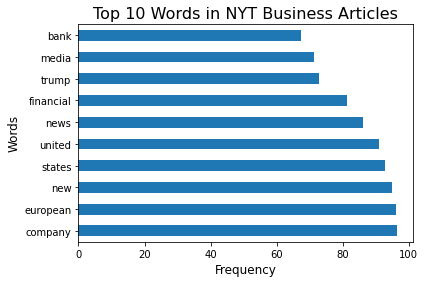

In [16]:
# plot top occuring words
tvec = TfidfVectorizer(stop_words='english')
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                          columns=tvec.get_feature_names())
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');
plt.title('Top 10 Words in NYT Business Articles', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Words', fontsize=12)

In [18]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB() )
])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).


pipe_tvec_params = {
    'tvec__max_features': [1000, 2000, 4000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)],
    'nb__alpha': [1,2]
}

# Instantiate GridSearchCV.
gs_2 = GridSearchCV(pipe_tvec, pipe_tvec_params, cv = 3)
gs_2.fit(X_train, y_train)
gs_2.score(X_train, y_train), gs_2.score(X_test, y_test)
%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [19]:
gs_2.best_params_

{'nb__alpha': 1,
 'tvec__max_features': 2000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

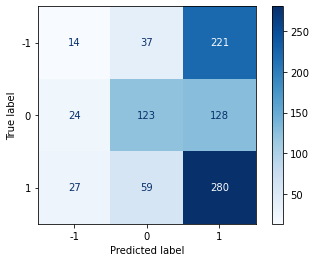

In [20]:
# Get predictions
preds_tvec = gs_2.predict(X_test)
# View confusion matrix
plot_confusion_matrix(gs_2, X_test, y_test, cmap='Blues');


In [21]:
accuracy_score(y_test, preds_tvec, sample_weight=None)

0.45673603504928806

## Running TFIDF and Multinomial Bayes on Best Params

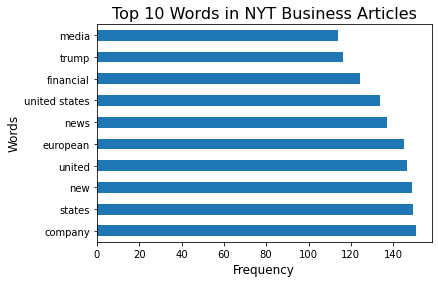

In [44]:
# plot top occuring words
tvec = TfidfVectorizer(stop_words='english', max_features = 2000, ngram_range= (1,2))
tvec_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), columns=tvec.get_feature_names())
tvec_df.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Top 10 Words in NYT Business Articles', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Words', fontsize=12);

In [51]:
daily.head(1)

,Unnamed: 0,date,text,price,pct_change,price_direction,day_of_week,is_holiday,vader_compound,textblob_polarity
1,1,2011-07-30,global concern over us debt ceiling disagreeme...,1292.28,0.0,0,5,0,0.664,0.072709


In [45]:
tvec_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2921 entries, 0 to 2920
Columns: 2000 entries, 10 to zuckerberg mark
dtypes: float64(2000)
memory usage: 44.6 MB


In [58]:
#merging vectorized dataframe with original dataset including sentiment analysis. More features!
merged_df = tvec_df.join(daily, how='inner',lsuffix= '_')
merged_df.head(2)


,10,100,11,12,13,14,15,16,18,20,...,Unnamed: 0,date,text,price,pct_change,price_direction,day_of_week,is_holiday,vader_compound,textblob_polarity
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,2011-07-30,global concern over us debt ceiling disagreeme...,1292.28,0.0,0,5,0,0.6640,0.072709
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,2011-07-31,deal may avert default but some ask is that go...,1292.28,0.0,0,6,0,0.9962,0.094384


In [ ]:
#setting date as index and dropping text column for modeling
merged_df.set_index('date', inplace=True)
merged_df.sort_index(inplace=True)

merged_df.drop(columns= ['text'], inplace=True)

In [62]:
merged_df.info()
#anything without relevant text data was dropped, went from 3652 entries to 2920

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2920 entries, 1 to 2920
Columns: 2010 entries, 10 to textblob_polarity
dtypes: float64(2004), int64(4), object(2)
memory usage: 44.8+ MB


### Train Test Split

In [75]:
X = merged_df.drop(columns= ['price_direction'])
y = merged_df['price_direction']

In [76]:
#sticking with a test size of 0.20 to save 2 years of data to test on
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False, test_size=0.2)


In [79]:
# multinuomial bayes cannot handle negative value features, so scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [81]:
mb = MultinomialNB(alpha=1)
mb.fit(X_train, y_train)

mb.score(X_train, y_train), mb.score(X_test, y_test)

(0.7303082191780822, 0.5513698630136986)

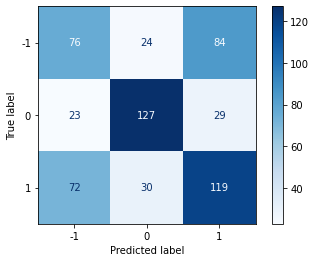

In [82]:
# predictions
preds = mb.predict(X_test)

# View confusion matrix
plot_confusion_matrix(mb, X_test, y_test, cmap='Blues');


In [84]:
accuracy_score(y_test, preds, sample_weight=None)
#aim for best accuracy, but also reduce false positives and negatives. 

0.5513698630136986

In [85]:
# calculate null accuracy (for multi-class classification problems)
# .head(1) assesses the value 1208
null_accuracy = y_test.value_counts().head(1) / len(y_test)
print('Null accuracy:', null_accuracy)

Null accuracy: 1    0.378425
Name: price_direction, dtype: float64


In [92]:
# print message text for the false negatives (spam incorrectly classified as ham)

fn= pd.DataFrame(X_test[preds < y_test])
fn['vader_compound']
# alternative less elegant but easier to understand
# X_test[(y_pred_class=0) & (y_test=1)]

KeyError: 'vader_compound'

# TODO" model best params with multinomial bayes, how accurate is it?

multinomial bayes non-lemmatized
knnclassifier? grid search

Try all out with open price

Try RNN

## Evaluation of Models

#### With lemmatization

TFIDF
{'tvec__max_features': 4000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': None}
 
 {'tvec__max_features': 2000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': None,
 'tvec__sublinear_tf': True}
 
CVEC
 {'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2)}
 
accuracy score with TFIDF and multinomial bayes:  52.4%
accuracy score with CVEC and multinomial bayes: 44.2%
 
 
 
 
#### Non-lemmatized
 
 
 
 {'tvec__max_features': 2000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': None,
 'tvec__sublinear_tf': True}
accuracy score with TFIDF and multinomial bayes:  52.13%


{'nb__alpha': 1,
 'tvec__max_features': 1000,
 'tvec__ngram_range': (1, 1),
 'tvec__sublinear_tf': True}
 
accuracy score with TFIDF and multinomial bayes:  54.22%

{'nb__alpha': 1,
 'tvec__max_features': 1000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english',
 'tvec__sublinear_tf': True}
 accuracy score with TFIDF and multinomial bayes:  47.10%
 
 
 {'nb__alpha': 1,
 'tvec__max_features': 2000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}
 
 accuracy score with TFIDF and multinomial bayes:  45.67%



models with sublinear_tf were removing/transforming the data of down days and altering predictions. those models will not be used.